In [3]:
import re
import requests
import json
import os

import networkx as nx
import numpy as np

Open .txt file copied from wikipedia page where links that did not correspond to music artists were removed.

In [4]:
with open("wikipage.txt", "r", encoding="utf-8") as f:
        wiki_text = f.read()

match_wiki = re.findall(r'\[\[(.*?)\]\]', wiki_text) 
len(match_wiki)

FileNotFoundError: [Errno 2] No such file or directory: 'wikipage.txt'

Clean artists names for next task:
- remove | and characters that come next;
- keep everything else the same so we can use this list to acess wikipedia again when creating a .txt file for each artist.

In [19]:
match_wiki_clean=[]
for m in match_wiki:
    short_m = m.split('|')[0]
    match_wiki_clean.append(short_m)

len(match_wiki_clean) == len(match_wiki)

True

Create a .txt file for each artist:
- In Shakin Stevens wikipedia page The Rolling Stones appear as "the Rolling Stones" so files are saved in lowercase.

In [20]:
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
rvslots = "rvslots=main"
headers = {"User-Agent" : "MyWikipediaClient/1.0 (example@example.com)"} # just use this dict as-is.

folder_name = "artist_texts"
os.makedirs(folder_name, exist_ok=True)

for m in match_wiki_clean:
    title = "titles=" + m
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat, rvslots)
    
    wikiresponse = requests.get(query, headers=headers)
    wikidata = wikiresponse.text
    dict_data=json.loads(wikidata)

    key_number=list(dict_data['query']['pages'].keys())[0]
    page = dict_data['query']['pages'][str(key_number)]

    if 'revisions' in page and len(page['revisions']) > 0:
        wiki_text = page['revisions'][0].get('*', '')
    else:
        wiki_text = ''
        print("No revisions found for artist " + m)

    #for AC/DC remove / --> ACDC
    # if m=="AC/DC":
    m = m.replace("/", "")

    # #save the file name in lowercase
    lower_case_path=m.lower()

    file_path = os.path.join(folder_name, lower_case_path+".txt")
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(wiki_text)

No revisions found for artist Crosby, Stills, Nash & Young


Crosby, Stills, Nash & Young.txt is empty since *page['revisions']* does not work for this artist wikipedia page.

Create list of artists names in lowercase:
- AC/DC is corrected;
- files are in lower case;
- the link found in wikipedia will be compared to the filename and the artist list so all must be in lowercase (including wikipedia link after being extracted)

In [21]:
match_wiki_clean_lc=[]
for match in match_wiki_clean:
    if match=='AC/DC':
        match=match.replace("/", "")
    new_match = match.lower()
    match_wiki_clean_lc.append(new_match)

len(match_wiki_clean_lc)==len(match_wiki)

True

Create network:

In [22]:
folder_name = "artist_texts"
all_items = os.listdir(folder_name)
#all_items is in lower_case

G = nx.DiGraph()

#filename is in lowercase
for filename in all_items:

    #get files text
    artist_file_path = os.path.join(folder_name, filename)
    with open(artist_file_path, "r", encoding="utf-8") as f:
        artist_text = f.read()

    #count words 
    words = re.findall(r"[A-Za-z]+", artist_text)
    no_words=len(words)

    #get name of node, filename is str with .txt
    artist=filename.replace(".txt", "")

    #see if node already exits, from previous edges
    if G.has_node(artist):
        G.nodes[artist]["words"] = no_words
    else:
        G.add_node(artist,words=no_words)
    
    #extract all links from text
    links = re.findall(r'\[\[(.*?)\]\]', artist_text)
    link_artists = set()
    
    for link in links:

        #remove | and what comes next, make it lowercase and AC/DC
        if link == "AC/DC":
            link=link.replace("/","")
        link_short= link.split('|')[0]
        link_lower=link_short.lower() 

        #filter links to get artists
        #dont allow for multiple edges with same direction between the same nodes
        #dont allow a node to reference itself
        if link_lower in match_wiki_clean_lc and link_lower not in link_artists and link_lower != artist:
            link_artists.add(link_lower)
            G.add_edge(artist,link_lower)
        

In [23]:
no_nodes=G.number_of_nodes()
print(no_nodes == len(match_wiki))
print(no_nodes)

True
488


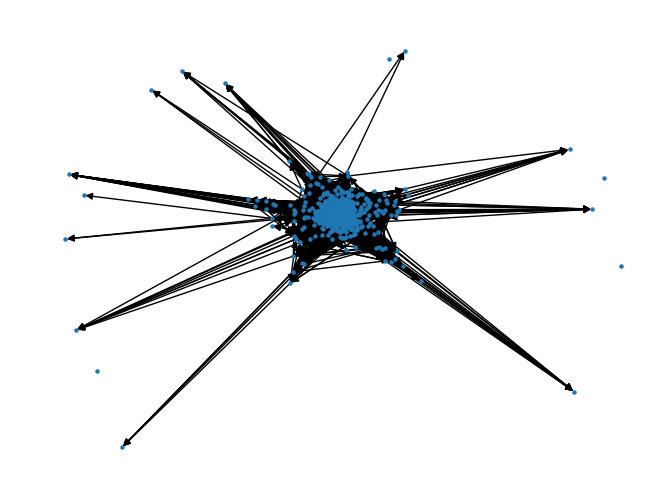

In [24]:
nx.draw(G, node_size=5)

In [25]:
for m in match_wiki_clean_lc:
    if m=="allmusic":
        print(m)

In [27]:
isolated_nodes = list(nx.isolates(G))
print("Isolated nodes:", isolated_nodes)

Isolated nodes: ['dr. hook & the medicine show', 'england dan & john ford coley', 'jet (australian band)', 'van zant (band)']


Check if for every node in the above list the in and out nodes are zero.

In [28]:
for node in isolated_nodes:
    in_nodes=G.in_degree(node)
    out_nodes=G.out_degree(node)
    print(node)
    print("Number of in nodes:", in_nodes)
    print("Number of out nodes:", out_nodes)

dr. hook & the medicine show
Number of in nodes: 0
Number of out nodes: 0
england dan & john ford coley
Number of in nodes: 0
Number of out nodes: 0
jet (australian band)
Number of in nodes: 0
Number of out nodes: 0
van zant (band)
Number of in nodes: 0
Number of out nodes: 0


In [29]:
G.remove_nodes_from(isolated_nodes)
G.number_of_nodes()

484

In [30]:
components = list(nx.weakly_connected_components(G))
largest_component = max(components, key=len)
G_largest = G.subgraph(largest_component).copy()

In [31]:
G_largest.number_of_nodes()

484

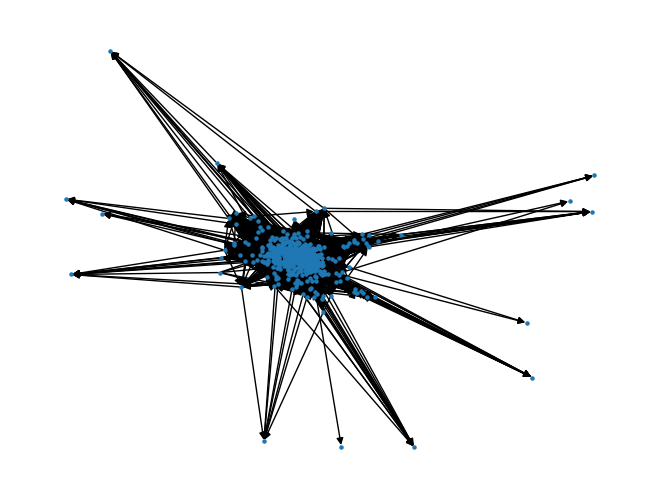

In [32]:
nx.draw(G_largest, node_size=5)

### **Notes on nodes**

Disconnected nodes:

- Dr hook: has no references on its wiki page of other artists
- England: redirect and no nodes coming in
- Jet: redirect and no nodes coming in
- Van zat: redirect and no nodes coming in

Not disconnected:
- Dallas: redirect but has 2 nodes coming in
- B52: redirect but has 4 nodes coming in
- Poison: redirects but has 14 nodes coming in
- Shankin stevens: has "the Rolling Stones" but it is solved

### **Notes on artists names' lists**

- Match wiki: original from wikipedia (has spaces, |, AC/DC)
- Match wiki clean: removed | (has spaces, AC/DC)
- All items: everything in lowercase and acdc (with spaces)
- Match wiki clean lc: everything in lowercase and acdc (with spaces)

Links have | removed, are lowercased and account for AC/DC since they will be compared with array *all items* and array *match wiki clean lc*.